In [4]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, pickle
from scipy.optimize import curve_fit
from PyAstronomy import pyasl
mpl.rcParams['font.family'] = 'serif'

In [5]:
full_catalog = pd.read_csv('SDSS12query_TOP99999.csv') # culled to only include *stars* with a quality rating of 3 (max)
full_catalog.rename(columns={'RA_ICRS': 'RA','DE_ICRS': 'DE','Sp-ID': 'SpID'}, inplace=True)
ugriz = {'umag':355.1,'gmag':468.6,'rmag':616.5,'imag':748.1,'zmag':893.1}
# https://en.wikipedia.org/wiki/Photometric_system for info on ugriz band letters

In [9]:
objList = full_catalog.copy().drop(['ObsDate','spType','pmRA','pmDE','chi2'],axis=1).dropna(subset=['subCl']) # unnecessary data
objList = objList[[any(Cl[0]==x for x in list("OBAFGKM")) & any(x in Cl for x in ['V','II','a','b']) for Cl in objList.subCl]]
for i in objList.index: # the above drops everything that is not a star with a standard spectral class. This loop parses the class
    Cl = objList.loc[i,'subCl'].strip().split()[0] # discard everything after a space, if one exists
    Cl = Cl.split('/')[-1] # take the second part after a /, if one exists
    objList.loc[i,'subCl'] = Cl # reassign the clean subCl
with open('goodlist.pkl','rb') as goodfile: # the model was run and dumped to a pickle file for easy access
    goodones = pickle.load(goodfile)

In [94]:
def planck(wavelength,T,amp): #in nm
    h = 6.626e-34 # Planck's constant, J*s
    c = 299792458 # speed of light, m/s
    k = 1.38064852e-23 # Boltzmann constant, J/K
    B = amp*((2*h*(c**2))/((wavelength*0.000000001)**5))*(np.exp((h*c)/((wavelength*0.000000001)*k*T))-1)**(-1) # Planck's Law
    return B # W/m^2/nm

def wien(T):
    b = 2.897771955e-3 # Wien's displacement constant, in m*K
    λ_max = (b/T)*1e9 # Wien's Law, with λ converted from nm
    return λ_max # in K

def ugriz_to_UBVRI(mags):
    u,g,r,i,z = [mag for mag in mags]
    UB = 0.78*(u-g) - 0.88
    BV = 0.98*(g-r) + 0.22
    VR = 1.09*(r-i) + 0.22
    RI = 1.00*(r-i) + 0.21
    B = g + 0.39*(g-r) + 0.21
    V = g - 0.59*(g-r) - 0.01
    U = UB+B
    R = V-VR
    I = R-RI
    return U,B,V,R,I

def ugriz_to_flux(ugrizmags,errors=np.zeros(5)):
    UBVRI = dict(zip(["U","B","V","R","I"],ugriz_to_UBVRI(ugrizmags))) 

    maxmag, minmag = ugriz_to_UBVRI(ugrizmags-errors), ugriz_to_UBVRI(ugrizmags+errors)
    fluxes, wavelengths, maxflux, minflux = pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([])
    
    for i in range(len(UBVRI)):
        fluxes[i], wavelengths[i] = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], UBVRI[list(UBVRI)[i]], "lam") # in CGS & Å
        maxflux[i], _ = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], maxmag[i], "lam")
        minflux[i], _ = pyasl.magToFluxDensity_bessel98(list(UBVRI)[i], minmag[i], "lam")
    
    wavelengths *= 0.1 # Ang to nm
    fluxes *= 1e-4*0.1/1e-7 # erg/s/cm^2/Ang to W/m^2/nm
    minflux *= 1e-4*0.1/1e-7
    maxflux *= 1e-4*0.1/1e-7
    
    negerrors, poserrors = fluxes-minflux, maxflux-fluxes
    
    return pd.DataFrame(zip(UBVRI.keys(),wavelengths,fluxes,negerrors,poserrors),columns=('band','wavelength','flux','e_neg','e_pos'))

sdj = pyasl.SpecTypeDeJager()

In [123]:
# Select object and obtain magnitudes
objIndex = np.random.choice(goodones) # pick a star to analyze
obj = 96757 #int(objIndex) #3792, 7935, 96757, 97148
SpID = objList.loc[obj,'SpID'] # parse plate, mjd, and fiber info
magnitudes = np.array(objList.loc[obj,ugriz.keys()]) # read the values of the magnitudes in each of the five ugriz channels
errors = np.array(objList.loc[obj,['e_'+band for band in ugriz.keys()]]) # read the corresponding rms errors

spectrum = ugriz_to_flux(magnitudes,errors)

# Fit data

fit_params, cov_mat = curve_fit(planck, spectrum['wavelength'], spectrum['flux'], p0=[7000,1e-30]) # (function,x,data,starting guesses)
uncertainties = np.sqrt(np.diag(cov_mat))
T = fit_params[0]
amp = fit_params[1]
λ_max = wien(T) # in nm, from temperature in K
baseλ = np.arange(250,1050)

spectrum['fit'] = planck(spectrum['wavelength'],*fit_params)
conf_region = (planck(baseλ,T-uncertainties[0],amp-uncertainties[1]), planck(baseλ,T+uncertainties[0],amp+uncertainties[1]))
fluxerrors = [spectrum['e_neg'],spectrum['e_pos']]


fit_residual = spectrum['flux'] - spectrum['fit']
fit_Rsquared = 1 - np.var(fit_residual)/np.var(spectrum['flux'])
fit_Chi_sq = np.sum((spectrum['flux'] - spectrum['fit'])**2/spectrum['fit'])

caption = "Obj temperature: %.2f \u00b1 %.3f K \nScaling factor: %.3e \u00b1 %.3e \nSpectrum peak λ: %.2f \u00b1 %.3f nm \nFit R-squared: %f" %(fit_params[0],uncertainties[0],fit_params[1],uncertainties[1],λ_max,wien(T)-wien(T+uncertainties[0]),fit_Rsquared)
print(caption)


# Calculate temp and luminosity based on stellar class

lumClass  = objList.loc[obj,'subCl'][2:].strip()
specClass = objList.loc[obj,'subCl'][:2]
Cl = specClass+lumClass

loglum, logTeff = sdj.lumAndTeff(specClass, lumClass)
lum, Teff = (10**loglum)*3.828e26, 10**logTeff
print("Stellar class: %s \nLuminosity: %.4e W \nTemperature: %.4f K" %(Cl,lum,Teff))
intFlux = np.sum(planck(np.arange(1,4000),*fit_params))
dist = np.sqrt(lum/(4*np.pi*intFlux))
print("Distance: %.4e m (%.1f ly)" %(dist,dist/9460730000000000))

Obj temperature: 6443.24 ± 83.189 K 
Scaling factor: 1.563e-28 ± 9.693e-30 
Spectrum peak λ: 449.74 ± 5.733 nm 
Fit R-squared: 0.986349
Stellar class: F2V 
Luminosity: 1.2619e+27 W 
Temperature: 6808.7366 K
Distance: 4.5609e+18 m (482.1 ly)


c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


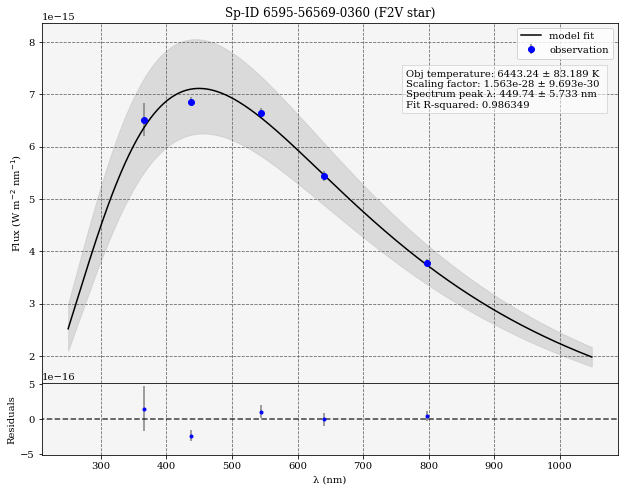

In [124]:
#Create main spectrum plot

fig, ax = plt.subplots(figsize=(8, 5))
fig.set_facecolor('white')

#Plot Data-model
main_frame = fig.add_axes((0,.2,1,1)).set_facecolor('whitesmoke')
plt.errorbar(spectrum['wavelength'],spectrum['flux'],fmt='ob',yerr=fluxerrors,ecolor='grey',label='observation')
plt.plot(baseλ, planck(baseλ,*fit_params), color='black',label='model fit')
plt.fill_between(baseλ, *conf_region, color='silver', alpha=.5)
plt.ylabel("Flux (W m$^{-2}$ nm$^{-1}$)")
xlimits = plt.gca().get_xlim()
plt.title(f"Sp-ID {SpID} ({Cl} star)")
plt.legend()
plt.grid(color='dimgrey', linestyle='--')

#Residual plot
res_frame = fig.add_axes((0,0,1,.2)).set_facecolor('whitesmoke')
plt.errorbar(spectrum['wavelength'],fit_residual,fmt='.b',yerr=fluxerrors,ecolor='grey')
plt.plot([0,2000],[0,0],'--k',alpha=.75) # 0 baseline
plt.ylabel('Residuals')
plt.gca().set_xlim(xlimits)
plt.gca().set_ylim(-1*max(np.abs(plt.gca().get_ylim())),max(np.abs(plt.gca().get_ylim())))
plt.gca().xaxis.grid(color='dimgrey', linestyle='--')
plt.xlabel("λ (nm)")
fig.text(.632,.965,caption,bbox=dict(facecolor='w',edgecolor='silver',alpha=0.5))
plt.savefig(f'example_{obj}.png',bbox_inches='tight')

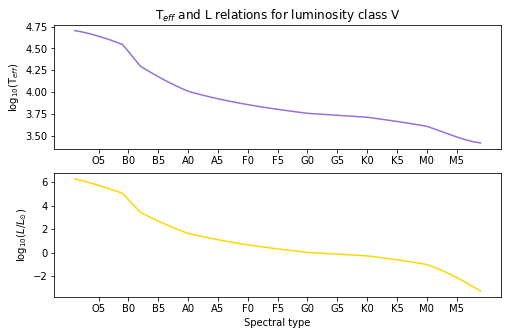

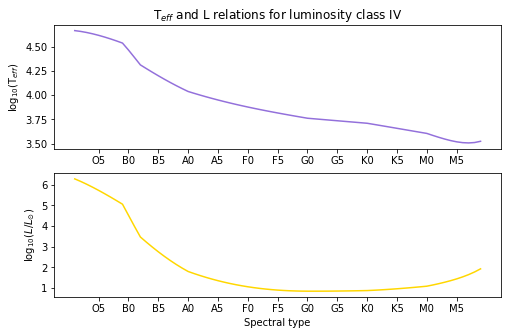

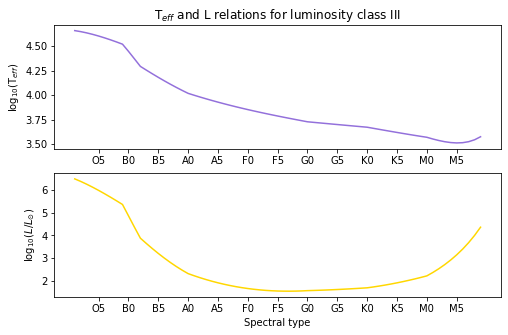

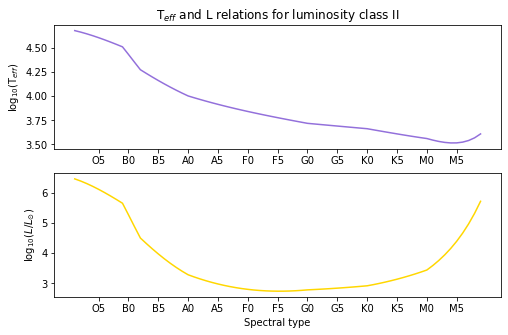

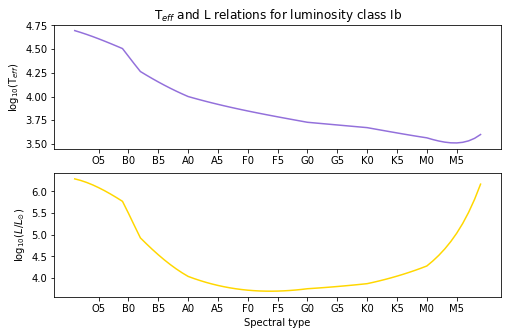

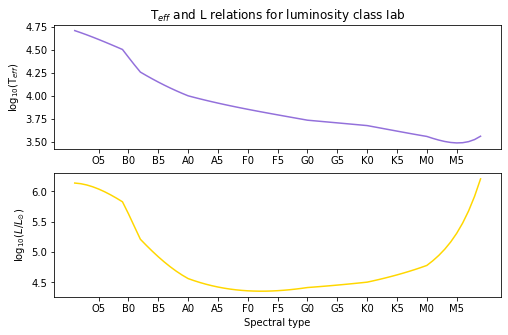

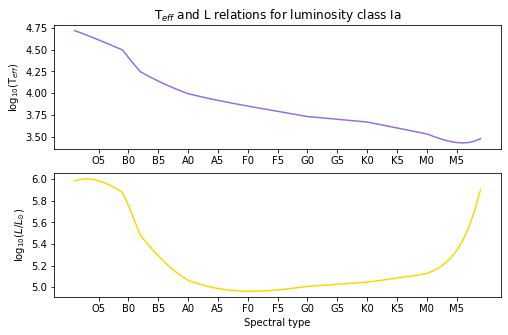

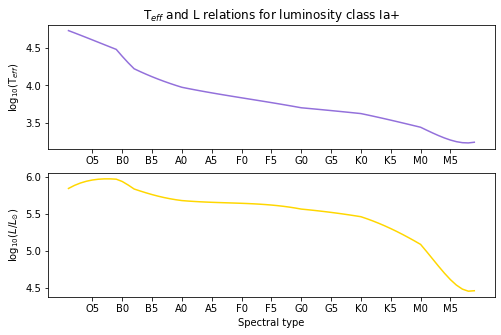

In [7]:
for lumClass in ['V', 'IV', 'III', 'II', 'Ib', 'Iab', 'Ia', 'Ia+']:
    # Save spectral types, log(teff), and log(luminosity)
    spts = []
    lteffs = []
    llums = []

    # Save information to mark up x-axis
    xt = []
    xtl = []

    for t in "OBAFGKM":
        for n in range(10):
            if (t == "O") and (n == 0):
                # "O0" type doesn't exist
                continue

            # Save the spectral type
            spts.append(t + str(n))

            # Get log10 of luminosity and effective temperature
            ll, lt = sdj.lumAndTeff(spts[-1], lumClass)
            # and save to lists
            llums.append(ll)
            lteffs.append(lt)

            if (n == 0) or (n == 5):
                xt.append(len(spts)-1)
                xtl.append(spts[-1])

    fig, _ = plt.subplots(figsize=(8,5))
    ax1 = plt.subplot(2,1,1)
    # Plot log10(effective temperature)
    plt.plot(lteffs, color='mediumpurple')
    plt.title("T$_{eff}$ and L relations for luminosity class %s" %lumClass)
    plt.ylabel("$\log_{10}$(T$_{eff}$)")
    plt.setp(ax1, xticks=xt,xticklabels=xtl)
    ax2 = plt.subplot(2,1,2)
    # Plot log10(luminosity)
    plt.plot(llums, color='gold')
    plt.ylabel("$\log_{10}$($L/L_{\odot}$)")
    plt.setp(ax2, xticks=xt,xticklabels=xtl)
    plt.xlabel("Spectral type")
    plt.savefig(f'LandTeff_{lumClass}.png')

In [87]:
# Mini five-point plots
'''
ugrizSpec.plot(kind='scatter',x='wavelength',y='ugriz_mag',color='red',marker='o',title=f'Object {SpID}: ugriz magnitude plot\n').set(xlabel='Wavelength (nm)',ylabel='Visual magnitude (urgriz)')
plt.show()
print(ugrizSpec)
plt.plot(UBVRIspec['wavelength'],UBVRIspec['flux'],'ro')
plt.title(f'Object {SpID}: UBVRI flux spectrum\n')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (W m$^{-2}$ nm$^{-1}$)')
plt.show()
print(UBVRIspec)
'''

"\nugrizSpec.plot(kind='scatter',x='wavelength',y='ugriz_mag',color='red',marker='o',title=f'Object {SpID}: ugriz magnitude plot\n').set(xlabel='Wavelength (nm)',ylabel='Visual magnitude (urgriz)')\nplt.show()\nprint(ugrizSpec)\nplt.plot(UBVRIspec['wavelength'],UBVRIspec['flux'],'ro')\nplt.title(f'Object {SpID}: UBVRI flux spectrum\n')\nplt.xlabel('Wavelength (nm)')\nplt.ylabel('Flux (W m$^{-2}$ nm$^{-1}$)')\nplt.show()\nprint(UBVRIspec)\n"

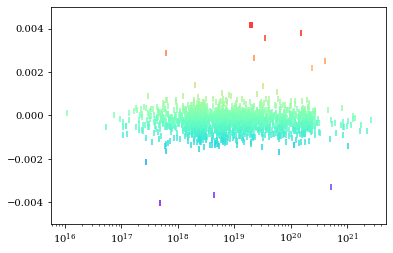

In [85]:
plt.scatter(list(distances),list(objList.loc[distances.index,'zsp']),marker='|',c=list(objList.loc[distances.index,'zsp']),cmap='rainbow')
plt.xscale('log')
plt.gca().set_ylim((-0.005,0.005))
plt.show()

In [99]:
obj

20572